# CompareAusKenyaData

This notebook downloads Bare-PV-NPV fractional cover estimates [generated by CSIRO](https://portal.tern.org.au/fractional-cover-modis-csiro-algorithm/21786) for [Australia](https://eo-data.csiro.au/remotesensing/v310/australia/monthly/cover/) and [Kenya](https://eo-data.csiro.au/remotesensing/v310/global/kenya/monthly/cover/), creates matching datasets using `earthlib`, and compares goodness-of-fit metrics. The goal is to quantify how well `earthlib` unmixing matches other published methods in order to estimate the confidence of prediction quality.

CSIRO provides fractional cover estimates derived from 8-day MODIS composites that are composited on a monthly basis and available from 2001-01-01 to today. These data are avaialble for two countries: Australia and Kenya. We'll pick just one arbitrary year - 2010 - and pull all the monthly data for each country. We'll then run `earthlib` unmixing for the same monthly ranges across both extents and export the raster files.

Once we have both co-aligned datasets, we'll randomly sample points from each country each month, extract the raster values for each location, then compare estimates between datasests for the Bare-PV-NPV fractions.

In [1]:
# packages
import os
import requests

import ee
import numpy as np
import pandas as pd
from sklearn import metrics
import geopandas as gpd
import rasterio as rio
import elapid as ela
from tqdm.notebook import tqdm
import artlo
from artlo import plt
from matplotlib import rcParams

import earthlib as eli

In [ ]:
ee.Initialize()

In [2]:
# set file and download paths
earthlib_dir = '/home/cba/src/earthlib'
data_dir = os.path.join(earthlib_dir, 'data')
earthengine_gdrive_dir = 'EarthEngine'
csiro_aus_dir = 'https://eo-data.csiro.au/remotesensing/v310/australia/monthly/cover'
csiro_ken_dir = 'https://eo-data.csiro.au/remotesensing/v310/global/kenya/monthly/cover'

In [3]:
# set dates and procesing parameters
year = 2010
months = range(1, 13)
end_dates = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
n_unmixing_iterations = 20
n_total_samples = 200000

In [4]:
# helper functions
def download_file(url: str, output_directory: str, chunk_size: int = 8192):
    filename = url.split('/')[-1]
    output_file = os.path.join(output_directory, filename)
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_file, 'wb') as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                f.write(chunk)
    return output_file

## Downloading CSIRO data

These data are hosted on a web server and can be directly retrieved with `wget` if you like, but we'll use the `requests` library to do so.

In [5]:
# download kenya first
download = False
kenya_basenames = []
for month in tqdm(months, desc='Kenya monthly download'):
    basename = f"FC.v310.MCD43A4.A{year}.{month:02d}.ken.006.tif"
    url = f"{csiro_ken_dir}/{basename}"
    if download:
        download_file(url, output_directory=data_dir)
    kenya_basenames.append(basename)

Kenya monthly download:   0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
# download aus next
aus_basenames = []
for month in tqdm(months, desc='Australia monthly download'):
    basename = f"FC.v310.MCD43A4.A{year}.{month:02d}.aust.006.tif"
    url = f"{csiro_aus_dir}/{basename}"
    if download:
        download_file(url, output_directory=data_dir)
    aus_basenames.append(basename)

Australia monthly download:   0%|          | 0/12 [00:00<?, ?it/s]

## Unmixing with `earthlib`

In order to compare the `earthlib` and CSIRO fractional cover estimates, we'll use the same spatial extents and projections to export matching data.

There will be some imprecision in the comparisons. CSIRO unmixes MODIS 8-day composites, then computes pixel-wise medians on a monthly basis. For `earthlib` we'll reduce the daily MODIS data to each month then apply the unmixing.

In [ ]:
# get the spatial references for the aus and kenya data (using the first month as reference data)
aus_ref = os.path.join(data_dir, aus_basenames[0])
ken_ref = os.path.join(data_dir, kenya_basenames[0])

with rio.open(ken_ref, 'r') as ksrc:
    kepsg = ksrc.crs.to_epsg()
    ksrs = f"EPSG:{kepsg}"
    kres = ksrc.res[0]
    kbounds = ee.Geometry.Rectangle(ksrc.bounds, proj=ksrs)

with rio.open(aus_ref, 'r') as asrc:
    aepsg = asrc.crs.to_epsg()
    asrs = f"EPSG:{aepsg}"
    ares = asrc.res[0]
    abounds = ee.Geometry.Rectangle(asrc.bounds, proj=asrs)

In [ ]:
# unmix the monthly data
sensor = 'MODIS'
collection = ee.ImageCollection(eli.getCollection(sensor))
unmixing_bands = eli.getBands(sensor)
mask_function = eli.Mask.bySensor(sensor)
scaler = eli.getScaler(sensor)
eli.Unmix.Initialize(sensor, n_unmixing_iterations, unmixing_bands)

unmixed_imgs = []

for month, end_date in zip(months, end_dates):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = ee.Date.fromYMD(year, month, end_date)
    date_filter = ee.Filter.date(start_date, end_date)
    
    refl_img = collection.filter(date_filter).mean().select(unmixing_bands).multiply(scaler)
    unmixed = eli.Unmix.SVN(refl_img, shade_normalize=True).select([0,1,2]).multiply(100).toInt16()
    unmixed_imgs.append(unmixed)

In [ ]:
# clip and export for each extent
maxPixels = 1e13
skipEmptyTiles = True
scale = 500

# export at 500m because EE requires resolution in meters, and that's the approximate output of the CSIRO data

for month, img in zip(months, unmixed_imgs):
    kpath = f"FC.v310.EARTHLIB.A{year}.{month:02d}.ken.006.tif"
    task = ee.batch.Export.image.toDrive(
        img,
        description=kpath,
        folder=earthengine_gdrive_dir,
        fileNamePrefix=kpath,
        region=kbounds,
        scale=scale,
        crs=ksrs,
        maxPixels=maxPixels,
        skipEmptyTiles=skipEmptyTiles,
    )
    task.start()
    
    apath = f"FC.v310.EARTHLIB.A{year}.{month:02d}.aust.006.tif"
    task = ee.batch.Export.image.toDrive(
        img,
        description=apath,
        folder=earthengine_gdrive_dir,
        fileNamePrefix=apath,
        region=abounds,
        scale=scale,
        crs=asrs,
        maxPixels=maxPixels,
        skipEmptyTiles=skipEmptyTiles,
    )
    task.start()

## Raster data preparation

Once the files above are exported from Earth Engine to Google Drive, download them to the `data_dir` for preprocessing.

The first step will be to resample the raster data to the same resolution and extent as the original datasets. This is an annoying step to perform, because we introduce some uncertainty by resampling. But it's necessary because Earth Engine requires you export data in meters, while the original data are in lat/lon, and there's no uniform meters-to-degrees conversion to apply, meaning the output from EE will be close but not perfect. So we'll resample using `rasterio` because it's more fun to write than `gdal`.

We'll be using the extent and resolution from the CSIRO data, using cubic convolution instead of nearest neighbor resampling to try take advantage of the continuous nature of the unmixed values. I'd stick with nearest if we were resampling raw reflectance data to preserve the observed spectral response wherever possible (instead of interpolating), but the unmixing values should lend themselves to interpolation.

In [8]:
# get the spatial references for the aus and kenya data (using the first month as reference data)
rerun = False
aus_ref = os.path.join(data_dir, aus_basenames[0])
ken_ref = os.path.join(data_dir, kenya_basenames[0])

with rio.open(ken_ref, 'r') as ksrc:
    kres = ksrc.res
    kbounds = ksrc.bounds
    kprofile = ksrc.profile.copy()

with rio.open(aus_ref, 'r') as asrc:
    ares = asrc.res
    abounds = asrc.bounds
    aprofile = asrc.profile.copy()

if rerun:
    for month in tqdm(months, desc="Month"):
        # fortunately we had a typo where `.tif` was specified twice in the export.
        # so we can use just one for the resampled data
        k_input_path = os.path.join(data_dir, f"FC.v310.EARTHLIB.A{year}.{month:02d}.ken.006.tif.tif")
        a_input_path = os.path.join(data_dir, f"FC.v310.EARTHLIB.A{year}.{month:02d}.aust.006.tif.tif")

        k_output_path = k_input_path[:-4]
        a_output_path = a_input_path[:-4]

        # we'll use virtual VRTs to run tiled read/writes and resample on the fly
        with rio.open(k_input_path, 'r') as ksrc:
            with rio.vrt.WarpedVRT(ksrc, **kprofile) as kvrt:
                windows = [window for _, window in kvrt.block_windows()]
                with rio.open(k_output_path, 'w', **kprofile) as kdst:
                    for window in tqdm(windows, leave=False, desc="Kenya"):
                        kdst.write(kvrt.read(window=window), window=window)

        with rio.open(a_input_path, 'r') as asrc:
            with rio.vrt.WarpedVRT(asrc, **aprofile) as avrt:
                windows = [window for _, window in avrt.block_windows()]
                with rio.open(a_output_path, 'w', **aprofile) as adst:
                    for window in tqdm(windows, leave=False, desc='Australia'):
                        adst.write(avrt.read(window=window), window=window)

        # remove the original file
        os.remove(k_input_path)
        os.remove(a_input_path)

In [ ]:
# transfer the nodata values from the input data to the earthlib data
for month in tqdm(months, desc="Month", leave=True):
    k_earthlib_path = os.path.join(data_dir, f"FC.v310.EARTHLIB.A{year}.{month:02d}.ken.006.tif")
    k_csiro_path = os.path.join(data_dir, f"FC.v310.MCD43A4.A{year}.{month:02d}.ken.006.tif")
    a_earthlib_path = os.path.join(data_dir, f"FC.v310.EARTHLIB.A{year}.{month:02d}.aust.006.tif")
    a_csiro_path = os.path.join(data_dir, f"FC.v310.MCD43A4.A{year}.{month:02d}.aust.006.tif")
    
    with rio.open(k_csiro_path, 'r') as csiro_src, rio.open(k_earthlib_path, 'r+') as eli_src:
        eli_src.nodata = csiro_src.nodata
        windows = [window for _, window in csiro_src.block_windows()]
        for window in tqdm(windows, desc='Kenya', leave=False):
            csiro_data = csiro_src.read(window=window)
            eli_data = eli_src.read(window=window)
            
            # mask the source nodata as well as any nan/inf values
            nd_mask = csiro_data == csiro_src.nodata
            valid = np.isfinite(eli_data)
            eli_data[nd_mask] = csiro_src.nodata
            eli_data[~valid] = csiro_src.nodata
            
            eli_src.write(eli_data, window=window)
            
    with rio.open(a_csiro_path, 'r') as csiro_src, rio.open(a_earthlib_path, 'r+') as eli_src:
        eli_src.nodata = csiro_src.nodata
        windows = [window for _, window in csiro_src.block_windows()]
        for window in tqdm(windows, desc='Australia', leave=False):
            csiro_data = csiro_src.read(window=window)
            eli_data = eli_src.read(window=window)
            
            nd_mask = csiro_data == csiro_src.nodata
            valid = np.isfinite(eli_data)
            eli_data[nd_mask] = csiro_src.nodata
            eli_data[~valid] = csiro_src.nodata
            
            eli_src.write(eli_data, window=window)

## Extracting raster sample values

Once we've resampled the data, we'll use `elapid` to generate random point samples for each month and each geography, then extract the raster values at those point locations. Once we have those datasets we can merge them into a single large dataframe for analysis.

We'll use the `n_total_samples` parameter set above to determine the approximate size of the full set of samples. We'll then split that up to draw samples proportionally from the Aus/Kenya data (with more points coming from the larger aus dataset) and also spread the number of samples across each month of the year.

In [9]:
# get the relative size of each region, accounting for the nodata fraction of each dataset
# (derived from gdalinfo -approx_stats to get the valid fraction)
asize = aprofile['width'] * aprofile['height'] * 0.484
ksize = kprofile['width'] * kprofile['height'] * 8.862

apct = asize / (asize + ksize)
kpct = ksize / (asize + ksize)

print(f"Aus sample pct: {apct:0.3f} | Kenya sample pct: {kpct:0.3f}")

a_total_samples = n_total_samples * apct
k_total_samples = n_total_samples * kpct
a_monthly_samples = int(a_total_samples / 12)
k_monthly_samples = int(k_total_samples / 12)

Aus sample pct: 0.515 | Kenya sample pct: 0.485


In [ ]:
# draw samples for each month and store in a list to concatenate later
samples = []
for month in tqdm(months, desc="Month"):
    k_earthlib_path = os.path.join(data_dir, f"FC.v310.EARTHLIB.A{year}.{month:02d}.ken.006.tif")
    k_csiro_path = os.path.join(data_dir, f"FC.v310.MCD43A4.A{year}.{month:02d}.ken.006.tif")
    a_earthlib_path = os.path.join(data_dir, f"FC.v310.EARTHLIB.A{year}.{month:02d}.aust.006.tif")
    a_csiro_path = os.path.join(data_dir, f"FC.v310.MCD43A4.A{year}.{month:02d}.aust.006.tif")
    
    # get the sample locations
    k_points = ela.sample_from_raster(k_csiro_path, k_monthly_samples)
    a_points = ela.sample_from_raster(a_csiro_path, a_monthly_samples)
    
    # read the raster values
    band_names = ['csiro_bare', 'csiro_pv', 'csiro_npv', 'eli_bare', 'eli_pv', 'eli_npv']
    k_samples = ela.raster_values_from_geoseries(k_points, [k_csiro_path, k_earthlib_path], labels=band_names)
    a_samples = ela.raster_values_from_geoseries(a_points, [a_csiro_path, a_earthlib_path], labels=band_names)
    
    # add additional metadata
    k_samples['country'] = 'Kenya'
    a_samples['country'] = 'Australia'
    k_samples['month'] = month
    a_samples['month'] = month
    
    samples.append(k_samples)
    samples.append(a_samples)
    
# merge the dataframes and save the outputs
merged_path = os.path.join(data_dir, 'aus-kenya-fcover-samples.gpkg')
merged = gpd.GeoDataFrame(pd.concat(samples, ignore_index=True), crs=k_samples.crs)
merged.to_file(merged_path, driver='GPKG')

## Comparing datasets

Now that we've got these datasets from each extent and each dataset, let's compare how they look.

In [10]:
reload = True
if reload:
    merged_path = os.path.join(data_dir, 'aus-kenya-fcover-samples.gpkg')
    merged = gpd.read_file(merged_path)

In [27]:
# overall performance
bare_rsq = metrics.r2_score(merged['csiro_bare'], merged['eli_bare'])
pv_rsq = metrics.r2_score(merged['csiro_pv'], merged['eli_pv'])
npv_rsq = metrics.r2_score(merged['csiro_npv'], merged['eli_npv'])

bare_rmse = np.sqrt(metrics.mean_squared_error(merged['csiro_bare'], merged['eli_bare']))
pv_rmse = np.sqrt(metrics.mean_squared_error(merged['csiro_pv'], merged['eli_pv']))
npv_rmse = np.sqrt(metrics.mean_squared_error(merged['csiro_npv'], merged['eli_npv']))

print(f"PV   | r2: {pv_rsq:0.2f} | rmse: {pv_rmse:0.2f}")
print(f"NPV  | r2: {npv_rsq:0.2f} | rmse: {npv_rmse:0.2f}")
print(f"Bare | r2: {bare_rsq:0.2f} | rmse: {bare_rmse:0.2f}")

PV   | r2: 0.85 | rmse: 9.41
NPV  | r2: 0.33 | rmse: 13.06
Bare | r2: 0.75 | rmse: 9.66


In [28]:
# by country
aus = merged[merged['country'] == 'Australia']
ken = merged[merged['country'] == 'Kenya']

abare_rsq = metrics.r2_score(aus['csiro_bare'], aus['eli_bare'])
apv_rsq = metrics.r2_score(aus['csiro_pv'], aus['eli_pv'])
anpv_rsq = metrics.r2_score(aus['csiro_npv'], aus['eli_npv'])
kbare_rsq = metrics.r2_score(ken['csiro_bare'], ken['eli_bare'])
kpv_rsq = metrics.r2_score(ken['csiro_pv'], ken['eli_pv'])
knpv_rsq = metrics.r2_score(ken['csiro_npv'], ken['eli_npv'])

abare_rmse = np.sqrt(metrics.mean_squared_error(aus['csiro_bare'], aus['eli_bare']))
apv_rmse = np.sqrt(metrics.mean_squared_error(aus['csiro_pv'], aus['eli_pv']))
anpv_rmse = np.sqrt(metrics.mean_squared_error(aus['csiro_npv'], aus['eli_npv']))
kbare_rmse = np.sqrt(metrics.mean_squared_error(ken['csiro_bare'], ken['eli_bare']))
kpv_rmse = np.sqrt(metrics.mean_squared_error(ken['csiro_pv'], ken['eli_pv']))
knpv_rmse = np.sqrt(metrics.mean_squared_error(ken['csiro_npv'], ken['eli_npv']))

print(f"PV   | r2: {apv_rsq:0.2f} | rmse: {apv_rmse:0.2f} | Australia")
print(f"PV   | r2: {kpv_rsq:0.2f} | rmse: {kpv_rmse:0.2f} | Kenya")
print(f"NPV  | r2: {anpv_rsq:0.2f} | rmse: {anpv_rmse:0.2f} | Australia")
print(f"NPV  | r2: {knpv_rsq:0.2f} | rmse: {knpv_rmse:0.2f} | Kenya")
print(f"Bare | r2: {abare_rsq:0.2f} | rmse: {abare_rmse:0.2f} | Australia")
print(f"Bare | r2: {kbare_rsq:0.2f} | rmse: {kbare_rmse:0.2f} | Kenya")

PV   | r2: 0.85 | rmse: 8.44 | Australia
PV   | r2: 0.84 | rmse: 10.34 | Kenya
NPV  | r2: 0.35 | rmse: 11.73 | Australia
NPV  | r2: 0.28 | rmse: 14.33 | Kenya
Bare | r2: 0.78 | rmse: 9.56 | Australia
Bare | r2: 0.69 | rmse: 9.77 | Kenya


In [31]:
# map out PV performance over each month
for month in months:
    sub = merged[merged['month'] == month]
    aus = sub[sub['country'] == 'Australia']
    ken = sub[sub['country'] == 'Kenya']
    aus_pv_rsq = metrics.r2_score(aus['csiro_pv'], aus['eli_pv'])
    ken_pv_rsq = metrics.r2_score(ken['csiro_pv'], ken['eli_pv'])
    print(f"Month {month:02d} | r2 | {aus_pv_rsq:0.2f} aus | {ken_pv_rsq:0.2f} ken")

Month 01 | r2 | 0.83 aus | 0.85 ken
Month 02 | r2 | 0.85 aus | 0.88 ken
Month 03 | r2 | 0.87 aus | 0.81 ken
Month 04 | r2 | 0.86 aus | 0.68 ken
Month 05 | r2 | 0.85 aus | 0.78 ken
Month 06 | r2 | 0.83 aus | 0.81 ken
Month 07 | r2 | 0.83 aus | 0.86 ken
Month 08 | r2 | 0.86 aus | 0.84 ken
Month 09 | r2 | 0.86 aus | 0.84 ken
Month 10 | r2 | 0.84 aus | 0.84 ken
Month 11 | r2 | 0.85 aus | 0.77 ken
Month 12 | r2 | 0.85 aus | 0.83 ken


## Plotting datasets

We'll plot the main scatterplot results of the comparison between the national-scale datasets, showing levels of agreement and disagreement across the ranges of each metric.

In [18]:
# set plot defaults
artlo.plot.set_style('salo-light')
figsize = (4, 4)
dpi = 200
gridsize = 50
mincnt = 10
bins = 'log'
cmap= 'inferno'
extent = [0, 100, 0, 100]
tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off'}
rcParams['axes.spines.right'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False
rcParams['axes.spines.top'] = False

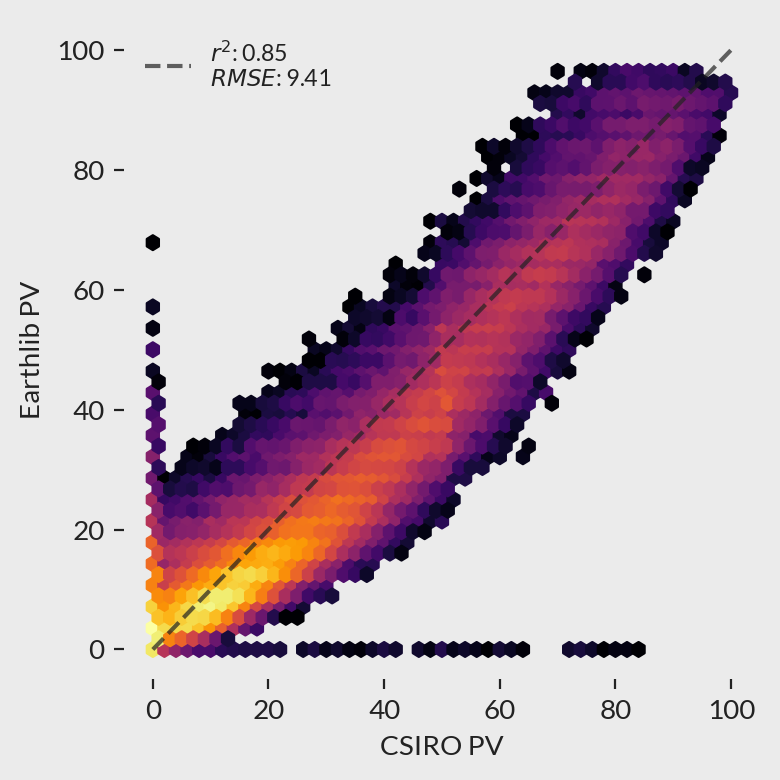

In [19]:
# plot green veg for all data
plt.figure(figsize=figsize, dpi=dpi)

# scatter plot
plt.hexbin(
    merged['csiro_pv'],
    merged['eli_pv'],
    extent=extent,
    gridsize=gridsize,
    mincnt=mincnt,
    bins=bins,
    cmap=cmap,
)

# 1:1 line
plt.plot(
    [0, 100],
    [0, 100],
    linestyle='--',
    alpha=0.7,
    color='#222222',
    label='$r^2$: ' + f'{pv_rsq:0.2f}\n' + '$RMSE$: ' + f'{pv_rmse:0.2f}'
)

# labels
plt.xlabel("CSIRO PV")
plt.ylabel("Earthlib PV")
plt.legend(fancybox=True, fontsize='small')
plt.tight_layout()

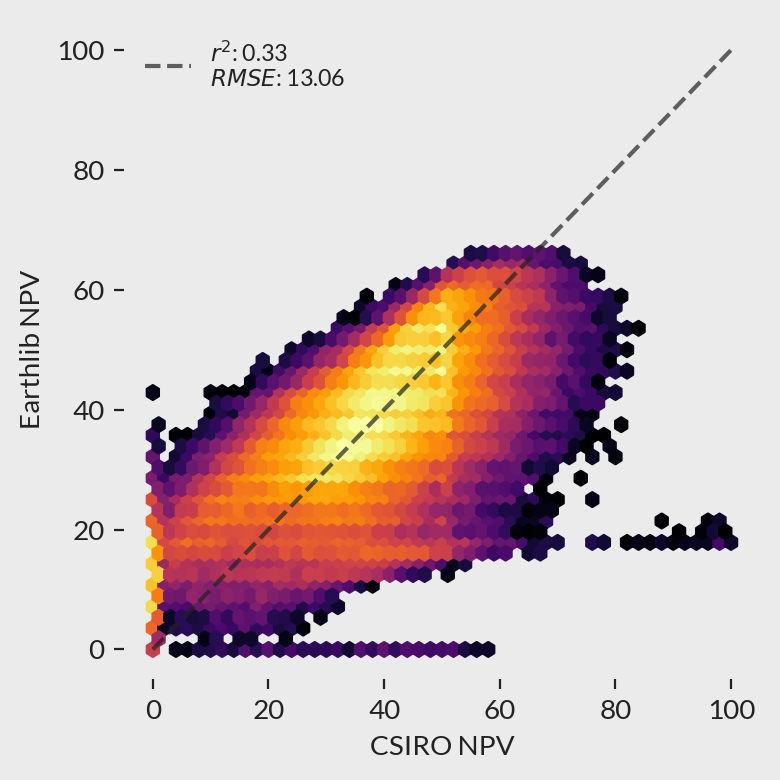

In [20]:
# plot green veg for all data
plt.figure(figsize=figsize, dpi=dpi)

# scatter plot
plt.hexbin(
    merged['csiro_npv'],
    merged['eli_npv'],
    extent=extent,
    gridsize=gridsize,
    mincnt=mincnt,
    bins=bins,
    cmap=cmap,
)

# 1:1 line
plt.plot(
    [0, 100],
    [0, 100],
    linestyle='--',
    alpha=0.7,
    color='#222222',
    label='$r^2$: ' + f'{npv_rsq:0.2f}\n' + '$RMSE$: ' + f'{npv_rmse:0.2f}'
)

# labels
plt.xlabel("CSIRO NPV")
plt.ylabel("Earthlib NPV")
plt.legend(fancybox=True, fontsize='small')
plt.tight_layout()

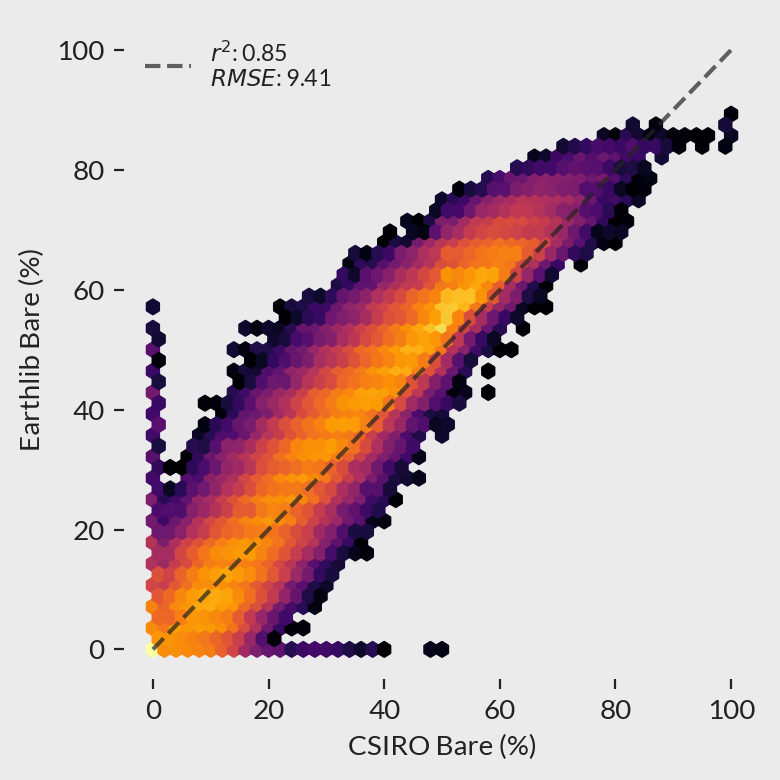

In [21]:
# plot green veg for all data
plt.figure(figsize=figsize, dpi=dpi)

# scatter plot
plt.hexbin(
    merged['csiro_bare'],
    merged['eli_bare'],
    extent=extent,
    gridsize=gridsize,
    mincnt=mincnt,
    bins=bins,
    cmap=cmap,
)

# 1:1 line
plt.plot(
    [0, 100],
    [0, 100],
    linestyle='--',
    alpha=0.7,
    color='#222222',
    label='$r^2$: ' + f'{pv_rsq:0.2f}\n' + '$RMSE$: ' + f'{pv_rmse:0.2f}'
)

# labels
plt.xlabel("CSIRO Bare (%)")
plt.ylabel("Earthlib Bare (%)")
plt.legend(fancybox=True, fontsize='small')
plt.tight_layout()